<a href="https://colab.research.google.com/github/RuthKassahun/Skin-Lesion-Classification/blob/main/Multi_Class_Color_Hist_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text** Color Histogram Multi class





## Import Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from PIL import Image, ImageOps
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix


## Load Data

In [2]:
SIZE = 224

In [4]:
def hist_features(img): 
  hist_blue = cv2.calcHist([img],[0],None,[256],[0,256]) #blue 
  hist_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
  hist_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
  hist=np.hstack([hist_green,hist_red,hist_blue]) 
  return hist.flatten()

In [5]:
#Resize images to 
SIZE = 224 
 
#Capture images and labels into arrays. 
#Start by creating empty lists. 
train_hist = [] 
train_label_hist = []  
for directory_path in glob.glob("/content/drive/MyDrive/Multiclass/multi_train/*"): 
    labelhist = directory_path.split("\\")[-1] 
    label = directory_path.split("/")[-1]
    #print(labelhist) 
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")): 
        #print(img_path) 
        img3 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images 
        img3 = cv2.resize(img3, (SIZE, SIZE)) #Resize images 
        img3=hist_features(img3) #call the function 
        train_hist.append(img3) 
        train_label_hist.append(labelhist) 
 
train_hist = np.array(train_hist) 
train_label_hist= np.array(train_label_hist)

In [8]:
print(np.unique(train_label_hist))

['/content/drive/MyDrive/Multiclass/multi_train/bcc'
 '/content/drive/MyDrive/Multiclass/multi_train/mel'
 '/content/drive/MyDrive/Multiclass/multi_train/scc']


In [9]:
test_hist = [] 
test_label_hist = []  
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("/content/drive/MyDrive/Multiclass/multi_val/*"):
    labelhist = directory_path.split("\\")[-1] 
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img4 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images 
        img4 = cv2.resize(img4, (SIZE, SIZE)) #Resize images 
        img4=hist_features(img4) #call the function 
        test_hist.append(img4) 
        test_label_hist.append(labelhist) 

test_hist = np.array(test_hist)
test_label_hist = np.array(test_label_hist)


## Label Encoding

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_label_hist)
test_labels_encoded = le.transform(test_label_hist)
le.fit(train_label_hist)
train_labels_encoded = le.transform(train_label_hist)

In [11]:
x_train, y_train, x_test, y_test = train_hist, train_labels_encoded, test_hist, test_labels_encoded

In [12]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [14]:
over=RandomOverSampler(random_state=0,sampling_strategy='minority')
X_res,Y_res=over.fit_resample(x_train,y_train)

In [15]:
print(sum(Y_res==0))

1993


In [16]:
over=RandomOverSampler(random_state=0,sampling_strategy='minority')
X_result,Y_result=over.fit_resample(X_res,Y_res)

In [17]:
print(sum(Y_result==0))

2713


## SVM

In [18]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [19]:
pipe1.fit(X_result,Y_result)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

Accuracy: 75.75%


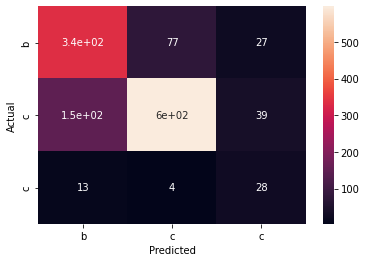

In [20]:
# Test set evaluation
prediction = pipe1.predict(x_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [21]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.5438367346938775


## Random Forest

In [22]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 42))
                 ])

In [23]:
pipe2.fit(X_result,Y_result)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 77.40%


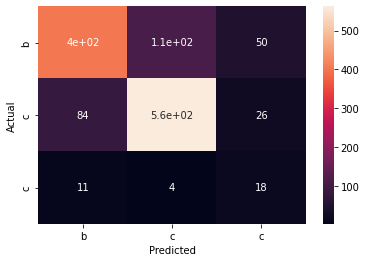

In [24]:
# Test set evaluation
prediction = pipe2.predict(x_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [25]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.582395750745865


## KNN

In [26]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [27]:
pipe3.fit(X_result,Y_result)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

Accuracy: 64.09%


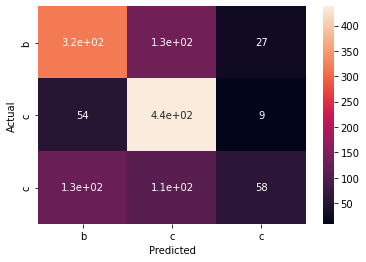

In [28]:
# Test set evaluation
prediction = pipe3.predict(x_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [29]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.4253758592770166


## AdaBoost

In [30]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_result,Y_result)

AdaBoostClassifier(n_estimators=200, random_state=0)

Accuracy: 62.68%


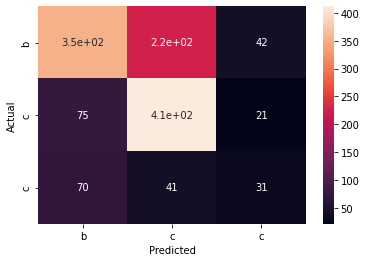

In [31]:
# Test set evaluation
prediction = clf.predict(x_test)
# Visualization
cmat = confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [32]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.36390495029417735


## XGB

In [33]:
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.1,objective='multi:softmax')
train_arr = np.array(X_result)
test_arr = np.array(Y_result)
mod1.fit(train_arr, test_arr)

XGBClassifier(booster='dart', objective='multi:softprob')

In [34]:
prediction = mod1.predict(x_test)
print("Accuracy = ", accuracy_score(test_labels_encoded, prediction))

Accuracy =  0.6858267716535433


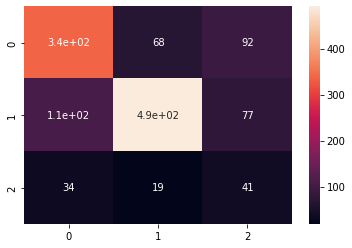

In [35]:
cm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm, annot=True)

In [36]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.4727384346450795


In [37]:
skf = StratifiedKFold(n_splits = 5)

In [38]:
# Defining a dictionary
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [0.1, 1, 5, 10, 100], #Regularization parameter.
            'kernel': ['rbf','linear','sigmoid','poly'], 
            'gamma':[0.00001,0.0001,0.001,0.01,0.1,1]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [30,50,70,100] #Trees: may lead to overfitting if n_estimators is too much
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 5, 9, 15, 19, 23, 27, 31, 35, 39]
        }
    }
}

In [39]:
scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=skf, n_jobs=6, #five fold cross validation
                         return_train_score=False)
    
    grid.fit(X_result,Y_result)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)

KeyboardInterrupt: ignored